This project requires Python 3.7 or above:

In [40]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn >/ 1.0.1:

In [41]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Get the data

# Download the Data

In [42]:
from pathlib import Path
# Importing visualisation libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

houseprice = pd.read_csv("houseprice.csv")

## Cleaning the data

Create a copy of the data as to not touch the raw data.

Begin to clean the data.

In [43]:
def clean_dataset():

    df_clean = houseprice.copy()

    # Dropping duplicates
    df_clean = df_clean.drop_duplicates()

    # Remove non-numeric characters from Price.
    if 'Price' in df_clean.columns:
        df_clean['Price'] = (df_clean['Price'].astype(str)
                             .str.replace(r'[$,+]', '', regex=True).str.strip())
        df_clean['Price'] = pd.to_numeric(df_clean['Price'], errors='coerce')

    # Removing non-numeric characters from last sold for
    if 'Last Sold For' in df_clean.columns:
        df_clean['Last Sold For'] = (df_clean['Last Sold For'].astype(str)
                                     .str.replace(r'[$,+]', '', regex=True).str.strip())
        df_clean['Last Sold For'] = pd.to_numeric(df_clean['Last Sold For'],
                                                  errors='coerce')
        
    # Removing units from Sqr Ft column
    if 'Sqr Ft' in df_clean.columns:
        df_clean['Sqr Ft'] = (df_clean['Sqr Ft'].astype(str)
                              .str.replace(r'[a-zA-Z, ]', '',regex=True).str.strip())
        df_clean['Sqr Ft'] = pd.to_numeric(df_clean['Sqr Ft'], errors='coerce')

    # Cleaning Lot Size column and converting the acres to square feet.
    if 'Lot Size' in df_clean.columns:
        # Detecting the rows which contain acres.
        is_acres = df_clean['Lot Size'].astype(str).str.contains('acre', case=False, na=False)

        #Removing units
        df_clean['Lot Size'] = (df_clean['Lot Size'].astype(str).str.replace
                                (r'[a-zA-Z, ]', '', regex=True).str.strip())
        df_clean['Lot Size'] = pd.to_numeric(df_clean['Lot Size'], errors='coerce')

        # converting the rows only which are in acres.
        df_clean.loc[is_acres, 'Lot Size'] *= 43560 #conversion to square feet.

    return df_clean
cleaned_df = clean_dataset()

# Display the cleaned dataset
print(cleaned_df.head())



      Price  Sqr Ft   Longitude   Latitude  Lot Size  Beds  Bath  Year Built  \
0  895900.0  3447.0 -112.081985  33.560055    7895.0   4.0   4.5      2019.0   
1  247000.0  1767.0  -96.676250  32.829227    7877.0   3.0   2.0      1954.0   
2   44900.0  1232.0  -78.825190  42.913000    3510.0   3.0   1.0      1900.0   
3  959000.0  1417.0  -73.860170  40.722960    2598.0   3.0   2.0      1939.0   
4   83500.0   440.0  -80.206314  25.937965       NaN   NaN   1.0      1971.0   

   Last Sold Year  Last Sold For  \
0             NaN            NaN   
1             NaN            NaN   
2             NaN            NaN   
3          2009.0       532000.0   
4          2007.0        52000.0   

                                            Address           City State  \
0                  630 W Echo Ln Phoenix, AZ 85021         Phoenix    AZ   
1                2367 Highwood Dr Dallas, TX 75228          Dallas    TX   
2                 30 Hurlock Ave Buffalo, NY 14211         Buffalo    NY  

In [44]:
null_rows_idx = cleaned_df.isnull().any(axis=1)
cleaned_df.loc[null_rows_idx].head()

,Price,Sqr Ft,Longitude,Latitude,Lot Size,Beds,Bath,Year Built,Last Sold Year,Last Sold For,Address,City,State,Zipcode,Address Full
0,895900.0,3447.0,-112.081985,33.560055,7895.0,4.0,4.5,2019.0,NaN,NaN,"630 W Echo Ln Phoenix, AZ 85021",Phoenix,AZ,85021.0,"630 W Echo Ln, Phoenix, AZ 85021"
1,247000.0,1767.0,-96.676250,32.829227,7877.0,3.0,2.0,1954.0,NaN,NaN,"2367 Highwood Dr Dallas, TX 75228",Dallas,TX,75228.0,"2367 Highwood Dr, Dallas, TX 75228"
2,44900.0,1232.0,-78.825190,42.913000,3510.0,3.0,1.0,1900.0,NaN,NaN,"30 Hurlock Ave Buffalo, NY 14211",Buffalo,NY,14211.0,"30 Hurlock Ave, Buffalo, NY 14211"
4,83500.0,440.0,-80.206314,25.937965,NaN,NaN,1.0,1971.0,2007.0,52000.0,"251 NW 177th St #A-123 Miami Gardens, FL 33169",Miami Gardens,FL,33169.0,"251 NW 177th St #A-123, Miami Gardens, FL 33169"
8,62900.0,748.0,-111.643486,33.422768,NaN,2.0,2.0,NaN,NaN,NaN,"8700 E University Dr #619 Mesa, AZ 85207",Mesa,AZ,85207.0,"8700 E University Dr #619, Mesa, AZ 85207"


In [45]:
from sklearn.impute import SimpleImputer

# Defining the columns
numerical_columns = ["Price", "Sqr Ft", "Lot Size", "Beds", "Bath", "Year Built"]

# Putting Last Sold Year and Last Sold For as categorical as they have too many missing values and imputing them as numerical would skew the data.
categorical_columns = ["Last Sold Year", "Zipcode", "Last Sold For"]

# Creating imputers
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

#Impute directly onto the dataframe.
cleaned_df[numerical_columns] = num_imputer.fit_transform(cleaned_df[numerical_columns])
cleaned_df[categorical_columns] = cat_imputer.fit_transform(cleaned_df[categorical_columns])

# Checking the results.
print("Remaining NaN values:")
print(cleaned_df[numerical_columns + categorical_columns].isna().sum())

# Viewing the previously null rows.
print("\nPreviously null rows(now imputed):")
print(cleaned_df.loc[null_rows_idx, numerical_columns + categorical_columns].head())

Remaining NaN values:
Price             0
Sqr Ft            0
Lot Size          0
Beds              0
Bath              0
Year Built        0
Last Sold Year    0
Zipcode           0
Last Sold For     0
dtype: int64

Previously null rows(now imputed):
      Price  Sqr Ft  Lot Size  Beds  Bath  Year Built  Last Sold Year  \
0  895900.0  3447.0    7895.0   4.0   4.5      2019.0          2017.0   
1  247000.0  1767.0    7877.0   3.0   2.0      1954.0          2017.0   
2   44900.0  1232.0    3510.0   3.0   1.0      1900.0          2017.0   
4   83500.0   440.0    7405.0   3.0   1.0      1971.0          2007.0   
8   62900.0   748.0    7405.0   2.0   2.0      1978.0          2017.0   

   Zipcode  Last Sold For  
0  85021.0       125000.0  
1  75228.0       125000.0  
2  14211.0       125000.0  
4  33169.0        52000.0  
8  85207.0       125000.0  


## Carry out data exploration. Visualise the data and showcase what you learn from the current housing market that could be valuable to the client.

AttributeError: QuadMesh.set() got an unexpected keyword argument 'centre'

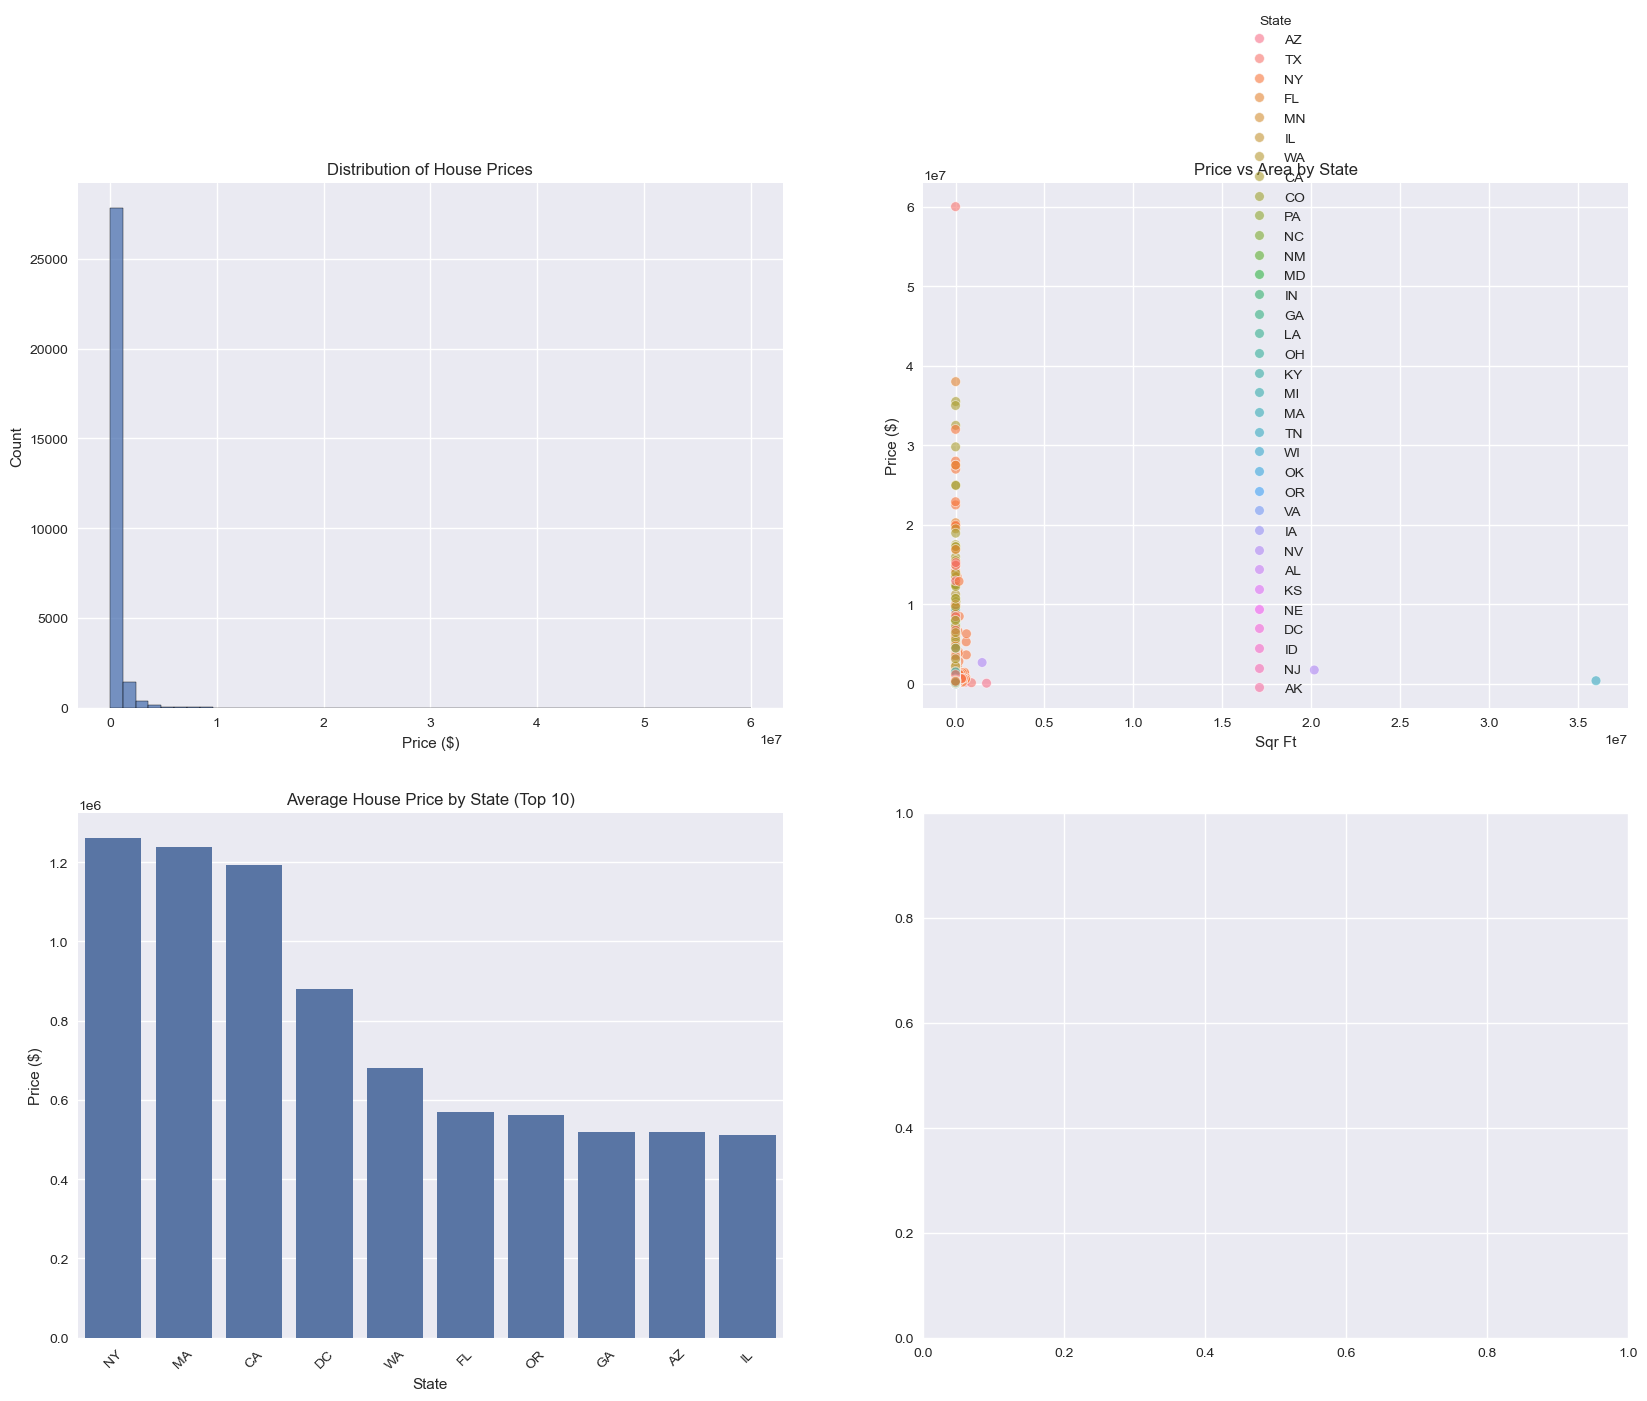

In [47]:
# Importing visualisation libraries.
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Setting the style for better visualization.
plt.style.use('seaborn-v0_8')

# First set of plots.
fig = plt.figure(figsize=(20,15))

# Price Distribution
plt.subplot(2,2,1)
sns.histplot(data=cleaned_df, x='Price', bins = 50)
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')

# Price vs Area with State coloring.
plt.subplot(2,2,2)
sns.scatterplot(data=cleaned_df, x='Sqr Ft', y='Price', hue='State', alpha=0.6)
plt.title('Price vs Area by State')
plt.xlabel('Sqr Ft')
plt.ylabel('Price ($)')

# Average Price by State.
plt.subplot(2,2,3)
state_prices = cleaned_df.groupby('State')['Price'].mean().sort_values(ascending=False)
sns.barplot(x=state_prices.index[:10], y=state_prices.values[:10])
plt.title('Average House Price by State (Top 10)')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Price ($)')

# Correlation Heatmap.
plt.subplot(2,2,4)
numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns
correlation = cleaned_df[numeric_columns].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', centre=0)
plt.title('Correlations Heatmap of Numeric Features')

plt.tight_layout()
plt.show()

# The Second Set of Plots.
fig = plt.figure(figsize=(20,10))

# Box Plot of Price by Beds.
plt.subplot(1,3,1)
sns.boxplot(data = cleaned_df, x='Beds', y='Price')
plt.title('Price Distribution by Number of Beds')
plt.xlabel('Number of Beds')
plt.ylabel('Price ($)')

# Price per Square Foot by state.
plt.subplot(1,3,2)
cleaned_df['price_per_sqrft'] = cleaned_df['Price'] / cleaned_df['Sqr Ft']
state_price_sqrft = cleaned_df.groupby('State')['price_per_sqrft'].mean().sort_values(ascending=False)
sns.barplot(x=state_price_sqrft.index[:10], y=state_price_sqrft.values[:10])
plt.title('Average Price per Square Foot by State (Top 10)')
plt.xticks(rotation=45)
plt.xlabel('State')
plt.ylabel('Price per Square Foot ($)')

# Visualisation of Clustering
plt.subplot(1,3,3)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Selecting the Features for Clustering
cluster_features = ['Price', 'Sqr Ft', 'Beds', 'Bath']
X = cleaned_df[cluster_features]

# Scaling the Features.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Performing K-means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cleaned_df['cluster'] = kmeans.fit_predict(X_scaled)

# Plotting clusters using the first 2 features.
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cleaned_df['cluster'], cmap='viridis')
plt.title('K-means Clustering Results\n(Price vs Sqr Ft)')
plt.xlabel('Standardized Price')
plt.ylabel('Standerdized Sqr Ft')

plt.tight_layout()
plt.show()

# Third set of plots to assess data quality.
fig = plt.figure(figsize=(15,5))

# Missing Values.
plt.subplot(1,3,1)
missing_values = cleaned_df.isnull().sum()
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.title('Missing Values by Feature')
plt.xticks(rotation=90)
plt.ylabel('Count')

# Feature Distribution
plt.subplot(1,3,2)
sns.boxplot(data=cleaned_df[clutser_features])
plt.title('Distribution of Key Features')
plt.xticks(rotation=45)

# Data Density
plt.subplot(1,3,3)

#Log transform the data for better visualization.
log_price = np.log1p(cleaned_df['Price'])
log_area = np.log1p(cleaned_df['Sqr Ft'])

# Create KDE plot with adjusted parameters.
sns.kdeplot(data={'Log Price': log_price, 'Log Area': log_area},
            common_norm=False, fill=True, alpha=0.5)


plt.title('Data Density Plot\n(Log-Tranformed Price vs Area)')
plt.xlabel('Log-Transformed Values')
plt.ylabel('Density')

#Add legend with orginal scale values.
plt.legend(labels=
           [f'Price (${cleaned_df.Price.min():,.0f} - ${cleaned_df.Price.max():,.0f})',
            f'Sqr Ft({cleaned_df["Sqr Ft"].min():,.0f} - {cleaned_df["Sqr Ft"].max():,.0f} sqft)'])

plt.tight_layout()
plt.show()

